## ResNET Training for MDSM
### 1. Instrall required pip package

In [16]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install --upgrade pandas
!pip install --upgrade torchsummary

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /usr/local/lib/python3.8/dist-packages (1.5.3)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: torchsummary in /usr/local/lib/python3.8/dist-packages (1.5.1)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 2. import required python packages

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from ResNet import Bottleneck, ResNet, ResNet50, ResNet18, ResNet34, ResNet101, ResNet152
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchvision import models
from torchsummary import summary
from datetime import datetime
from pytz import timezone

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 3. Define MDSMdata set for torch Dataset and Dataloader and other
* mix_random : For preventing overfitting (Mixing row randomly in MDSM metric
* flip_random : For preventing overfitting (Flip MDSM upside-down)

In [18]:
def mix_random(col, row, mdsm_body):
    size_suffle = random.randint(0,10)
    switchsource = torch.randint(0, row - 1, (size_suffle,))
    temp = np.zeros((1, col), np.float32)
    
    for i in range(0, int(size_suffle)):
        if i == switchsource[i]:
            continue
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[switchsource[i], :].copy()
        mdsm_body[switchsource[i], :] = temp.copy()
    return torch.tensor(mdsm_body)

def flip_random(col, row, mdsm_body):
    size_suffle = random.randint(0,12)
    if size_suffle % 4 != 0:
        return torch.tensor(mdsm_body)
    
    int_row = int(row)
    for i in range(0, int(int_row / 2)):
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[int_row - i - 1, :].copy()
        mdsm_body[int_row - i - 1, :] = temp.copy()
    return torch.tensor(mdsm_body)
    
class MDSMDataset(Dataset):
    def __init__(self, mdsmdata_file):
        self.df = pd.read_csv(mdsmdata_file)
        rating = self.df[['ReviewID', 'reviewStar']]
        self.rating = rating.drop_duplicates('ReviewID')
        self.height = self.df['ReviewID'].value_counts().max()

        mdsm_body = self.df.drop(['reviewNo', 'reviewStar'], axis=1)
        mdsm_body['imageCnt'] = (mdsm_body['imageCnt'] - mdsm_body['imageCnt'].min())/ (mdsm_body['imageCnt'].max() - mdsm_body['imageCnt'].min())
        mdsm_body['helpfulCnt'] = (mdsm_body['helpfulCnt'] - mdsm_body['helpfulCnt'].mean())/ mdsm_body['helpfulCnt'].std()
        body_height, body_width = mdsm_body.shape;
        self.width = body_width - 1

        dummy_mdsd = np.zeros((body_height, self.height, self.width), np.float32)
        mdsm_index = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_count = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_index.fill(-1)

        max_index = int(0)
        for index, body in mdsm_body.iterrows():
            dummy_index = max_index
            if mdsm_index[int(body['ReviewID'])] != -1:
                dummy_index = mdsm_index[int(body['ReviewID'])]
            else:
                mdsm_index[int(body['ReviewID'])] = dummy_index
                max_index = max_index + 1

            dummy_mdsd[dummy_index, mdsm_count[dummy_index]] = body.drop('ReviewID')
            mdsm_count[dummy_index] = mdsm_count[dummy_index] + 1

        self.mdsm_body = dummy_mdsd
            
    def __len__(self):
        return self.rating.shape[0]

    
    def __getitem__(self, idx):
        if trans_stat == True:
            _tensor = flip_random(self.width, self.height, self.mdsm_body[idx])
        else:
            _tensor = torch.tensor(self.mdsm_body[idx])
        rtn_tensor = _tensor.unsqueeze(0)
        return rtn_tensor, self.rating.iloc[idx, 1]

### 4. Hyperparameter setting
* epochs, batch_size ResNet layer number
* select ResNet model
* print out Model strucuture

In [19]:
EPOCHS = 400
BATCH_SIZE = 512
net_type = "ResNet34"

if net_type == "ResNet18":
    net = ResNet18(6, 1).to('cuda')
    print("ResNet18 is used")
elif net_type == "ResNet34":
    net = ResNet34(6, 1).to('cuda')
    print("ResNet34 is used")
elif net_type == "ResNet50":
    net = ResNet50(6, 1).to('cuda')
    print("ResNet50 is used")
elif net_type == "ResNet101":
    net = ResNet101(6, 1).to('cuda')
    print("ResNet101 is used")
elif net_type == "ResNet152":
    net = ResNet152(6, 1).to('cuda')
    print("ResNet152 is used")

summary(net, (1, 108, 12))

ResNet34 is used
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 54, 6]           3,136
       BatchNorm2d-2            [-1, 64, 54, 6]             128
              ReLU-3            [-1, 64, 54, 6]               0
         MaxPool2d-4            [-1, 64, 27, 3]               0
            Conv2d-5            [-1, 64, 27, 3]          36,864
       BatchNorm2d-6            [-1, 64, 27, 3]             128
           Dropout-7            [-1, 64, 27, 3]               0
           Dropout-8            [-1, 64, 27, 3]               0
            Conv2d-9            [-1, 64, 27, 3]          36,864
      BatchNorm2d-10            [-1, 64, 27, 3]             128
       BasicBlock-11            [-1, 64, 27, 3]               0
           Conv2d-12            [-1, 64, 27, 3]          36,864
      BatchNorm2d-13            [-1, 64, 27, 3]             128
          Dropout-14  

### 5. Load MDSM dataset from preprocesed csv file
* split train and test dataset into 8:2 ratio
* 6 kinds of classess [0, 1, 2, 3, 4, 5]

In [20]:
print('-- Loading dataset--')

dataset = MDSMDataset('amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size

print("Train(", train_size, ") vs Test(", test_size, ")")

print('-- Building train and test dataset / dataloader--')
train_dataset, test_dataset = random_split(dataset, [int(train_size),int(test_size)])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

classes = ['0', '1', '2', '3', '4', '5']


-- Loading dataset--
Train( 13188 ) vs Test( 3297 )
-- Building train and test dataset / dataloader--


### 6. Define mae and mse calcuating function

In [21]:
def calcu_metric(outputs, labels):
    mae = abs(outputs - labels)
    mse = torch.sqrt(mae)
    return mae, mse

### 7. Do ResNet training

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

correct = 0
total = 0

trans_stat = True
print('-- Start training : ', EPOCHS, 'epochs')

mse_history = {'train': [], 'val': []}
mae_history = {'train': [], 'val': []}
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

for epoch in range(EPOCHS):
    losses = []
    
    mse = np.zeros(train_size, np.float32)
    mae = np.zeros(train_size, np.float32)
    
    
    val_mse = np.zeros(test_size, np.float32)
    val_mae = np.zeros(test_size, np.float32)
    
    metric_index = 0
    
    running_loss = 0
    train_loss = 0
    train_acc = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()
        
        pred = outputs.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(labels.data.view_as(pred)).sum()
        

        _mae, _mse = calcu_metric(pred.squeeze(), labels)
        #print(_mse.detach().cpu().numpy())
        mae[metric_index:metric_index+len(inputs)] = _mae.detach().cpu().numpy()
        mse[metric_index:metric_index+len(inputs)] = _mse.detach().cpu().numpy()
        #print(torch.tensor(mse))
        metric_index += len(inputs)
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}/{EPOCHS}, {i}](epoch, minibatch): ', f'{running_loss / 100:.5f}')
            running_loss = 0.0

    mae_epoch = torch.mean(torch.tensor(mae))
    mse_epoch = torch.mean(torch.tensor(mse))
    
    mse_history['train'].append(mse_epoch)
    mae_history['train'].append(mae_epoch)
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
    
    metric_index = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = net(images)

            pred = outputs.data.max(1, keepdim=True)[1]
            _mae, _mse = calcu_metric(pred.squeeze(), labels)
            val_mae[metric_index:metric_index+len(images)] = _mae.detach().cpu().numpy()
            val_mse[metric_index:metric_index+len(images)] = _mse.detach().cpu().numpy()
            metric_index += len(images)           
        
    val_mae_epoch = torch.mean(torch.tensor(val_mae))
    val_mse_epoch = torch.mean(torch.tensor(val_mse))
    mse_history['val'].append(val_mse_epoch)
    mae_history['val'].append(val_mae_epoch)
    acc_history['train'].append((100. * train_acc / len(trainloader.dataset)).detach().cpu().numpy())
    
    train_loss /= len(trainloader.dataset)
    if EPOCHS > 50:
        if epoch % 5 == 0:
            print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")
    else:
        print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")

print('Training Done')
trans_stat = False

-- Start training :  400 epochs
Epoch: 0/400 Avg. loss:0.0037 Acc.: 55.7022%  MAE : 1.224 MSE : 0.713 VAL_MAE : 1.149 VAL_MSE : 0.677)
Epoch: 5/400 Avg. loss:0.0022 Acc.: 62.0640%  MAE : 0.955 MSE : 0.580 VAL_MAE : 0.971 VAL_MSE : 0.589)
Epoch: 10/400 Avg. loss:0.0021 Acc.: 63.1711%  MAE : 0.907 MSE : 0.556 VAL_MAE : 0.938 VAL_MSE : 0.574)
Epoch: 15/400 Avg. loss:0.0021 Acc.: 63.4365%  MAE : 0.895 MSE : 0.550 VAL_MAE : 0.942 VAL_MSE : 0.576)
Epoch: 20/400 Avg. loss:0.0020 Acc.: 63.6564%  MAE : 0.879 MSE : 0.544 VAL_MAE : 0.937 VAL_MSE : 0.574)
Epoch: 25/400 Avg. loss:0.0020 Acc.: 64.1113%  MAE : 0.860 MSE : 0.534 VAL_MAE : 0.950 VAL_MSE : 0.579)
Epoch: 30/400 Avg. loss:0.0020 Acc.: 64.3236%  MAE : 0.849 MSE : 0.529 VAL_MAE : 0.943 VAL_MSE : 0.577)
Epoch: 35/400 Avg. loss:0.0020 Acc.: 64.5966%  MAE : 0.840 MSE : 0.524 VAL_MAE : 0.948 VAL_MSE : 0.581)
Epoch: 40/400 Avg. loss:0.0020 Acc.: 64.6876%  MAE : 0.834 MSE : 0.521 VAL_MAE : 0.936 VAL_MSE : 0.577)
Epoch: 45/400 Avg. loss:0.0020 Acc

Epoch: 390/400 Avg. loss:0.0011 Acc.: 80.1335%  MAE : 0.537 MSE : 0.316 VAL_MAE : 0.994 VAL_MSE : 0.630)
Epoch: 395/400 Avg. loss:0.0011 Acc.: 80.1486%  MAE : 0.536 MSE : 0.315 VAL_MAE : 0.984 VAL_MSE : 0.625)
Training Done


### 8. Save model metrics into csv file
* Hyperparameter were written in filename

In [23]:
now = datetime.now(timezone('Asia/Seoul'))

hist_csv = np.stack([mae_history['val'], mse_history['val'], mae_history['train'], 
                     mse_history['train'], acc_history['train']], 1)
hist_csv_df = pd.DataFrame(hist_csv)
hist_csv_df.columns = ['validation_mae', 'validation_mse', 'train_mae', 'train_mse', 'train_accuracy']
time_str = now.strftime('%Y-%m-%d_%H:%M:%S')
hist_csv_df.to_csv("training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.csv"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
print("training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.csv saved"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))

training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-ResNet34_epochs-400-batch-512-2023-02-17_10:15:01.csv saved


### 9. Plot model metrics

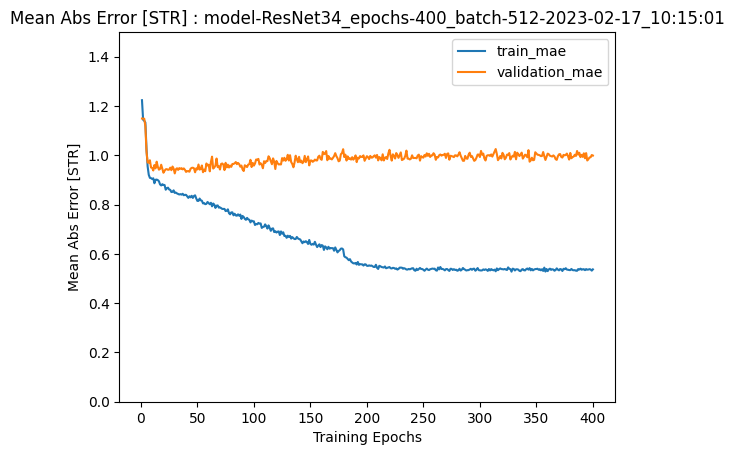

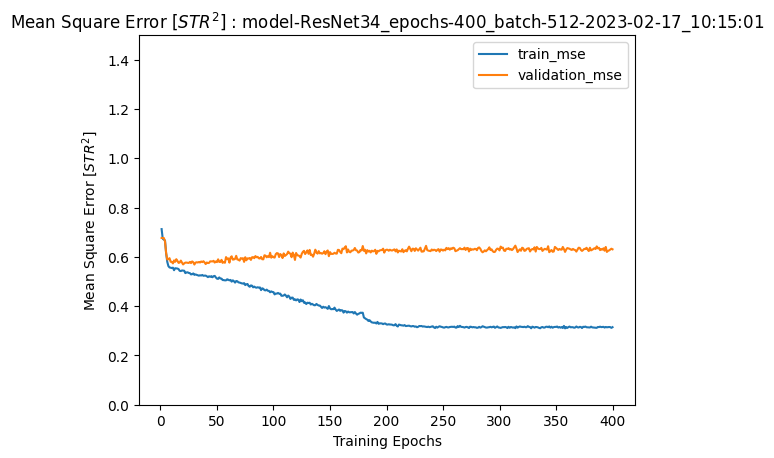

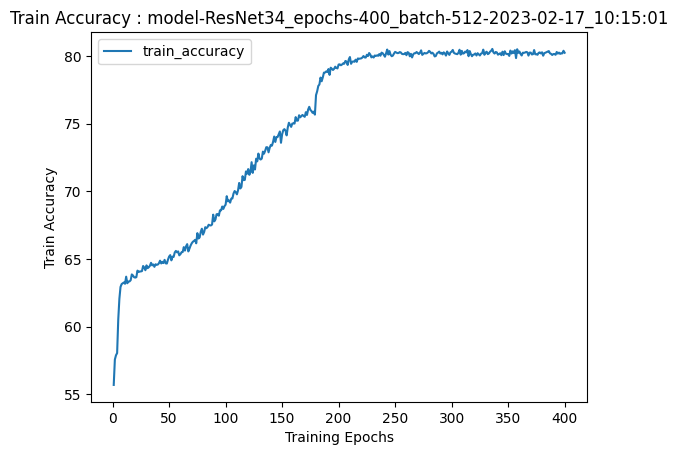

In [24]:
plt.title("Mean Abs Error [STR] : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),mae_history["train"],label="train_mae")
plt.plot(range(1,EPOCHS+1),mae_history["val"],label="validation_mae")
plt.ylabel("Mean Abs Error [STR]")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.show()

plt.title("Mean Square Error [$STR^2$] : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),mse_history["train"],label="train_mse")
plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation_mse")
plt.ylabel("Mean Square Error [$STR^2$]")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.show()


plt.title("Train Accuracy : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),acc_history["train"],label="train_accuracy")
#plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation mse")
plt.ylabel("Train Accuracy")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.show()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)

        print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)
        print(_,predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on,' ,total, 'test images: ', f'{100*(correct/total):.3f}', '%')